# Notebook 7: Variational Autoencoders (VAEs)


## __1.__ <a name="setup">Setup</a>


In [1]:
# Choose basedir as either local or hosted directory
import os
if "COLAB_BACKEND_VERSION" in os.environ:
    base_dir = "/content"
else:
    base_dir = os.getcwd()
# get helper code from the course repository
# install common packages used for deep learning
%cd $base_dir
!git clone https://github.com/cs449s23/lectures.git lectures/
%cd $base_dir/lectures/
!git pull -q origin main
!pip install -q -r requirements.txt

/Users/zachwooddoughty/Documents/CS449Lectures/lectures/notebooks
fatal: destination path 'lectures' already exists and is not an empty directory.
/Users/zachwooddoughty/Documents/CS449Lectures/lectures/notebooks/lectures


In [2]:
%matplotlib inline

import datetime
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from matplotlib.animation import FuncAnimation
from pathlib import Path
import time
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm import tqdm

from utils.gan import *

## __2.__ <a name="VAE">A Simple MNIST VAE</a>

In the previous notebook, we saw a "standard" autoencoder. Its encoder maps the input image into a latent space, and the decoder maps it back to the image space, but we don't put any constraints on the latent space itself.

Over the past week, we've discussed variational inference and how they can inform our creation of a VAE, which is what we'll explore in this notebook.

The following code is very similar to the autoencoder notebook from last week, but with a few crucial differences. First, our encoder outputs two tensors: `mu` and `log_var`. Our model then has a `sample` method which turns these two tensors into a `z` sample, which we then pass to our decoder as before. Finally, in addition to reconstruction loss, we are calculating the KL divergence between our latent space and a Normal distribution.

Q: why do we have our encoder output the log of the variance, rather than just the variance?

In [3]:
class MLPVAEEncoder(torch.nn.Module):
    
    def __init__(self, 
                 number_of_hidden_layers: int, 
                 input_size: int, 
                 hidden_size: int, 
                 latent_size: int,
                 activation: torch.nn.Module):
        """Construct a simple MLP encoder"""
        
        super().__init__()
        
        assert number_of_hidden_layers >= 0, "Encoder number_of_hidden_layers must be at least 0"
        
        dims_in = [input_size] + [hidden_size] * (number_of_hidden_layers - 1)
        dims_out = [hidden_size] * number_of_hidden_layers
        layers = []
        for i in range(number_of_hidden_layers):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))
            
            if i < number_of_hidden_layers - 1:
                layers.append(activation)

        self.shared = torch.nn.Sequential(*layers)
        self.mu = torch.nn.Linear(hidden_size, latent_size)
        self.log_var = torch.nn.Linear(hidden_size, latent_size)
    
    def forward(self, x: torch.Tensor):
        x = self.shared(x)
        return (self.mu(x), self.log_var(x))


class MLPDecoder(torch.nn.Module):
    
    def __init__(self, 
                 number_of_hidden_layers: int, 
                 latent_size: int, 
                 hidden_size: int, 
                 input_size: int,
                 activation: torch.nn.Module):
        """Construct a simple MLP decoder"""
        
        super().__init__()
        
        assert number_of_hidden_layers >= 0, "Decoder number_of_hidden_layers must be at least 0"
        
        dims_in = [latent_size] + [hidden_size] * number_of_hidden_layers
        dims_out = [hidden_size] * number_of_hidden_layers + [input_size]  # final output is an image
        
        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))
            
            if i < number_of_hidden_layers:
                layers.append(activation)
        
        # apply Tanh after final layer to bound pixels to range [-1, 1]
        layers.append(torch.nn.Sigmoid())
        
        self.net = torch.nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor):
        return self.net(x)


class MLPVAE(torch.nn.Module):
                          
    def __init__(self, 
                 number_of_hidden_layers: int, 
                 input_size: int, 
                 hidden_size: int, 
                 latent_size: int,
                 activation_encoder: torch.nn.Module = torch.nn.ReLU(),
                 activation_decoder: torch.nn.Module = torch.nn.LeakyReLU(0.2)
                ):
        """Construct a simple MLP *variational* autoencoder
        
        number_of_hidden_layers: An int. Must be >=0. Defines the number of
                hidden layers for both the encoder E and decoder D 
        latent_size:  An int. Defines the size of the latent representation produced by
                      the encoder.
        hidden_size: An int. The size of each hidden layer for the encoder E and
                     the decoder D.
        input_size: An int. Determines the size of the input and output images
        activation_encoder: A torch.nn.Module defining the activation function in every 
                            hidden layer of the encoder.
        activation_decoder: A torch.nn.Module defining the activation function in every 
                            hidden layer of the decoder.
        """
        super().__init__()
                          
        self.encoder = MLPVAEEncoder(
            number_of_hidden_layers=number_of_hidden_layers, 
            input_size=input_size, 
            hidden_size=hidden_size, 
            latent_size=latent_size,
            activation=activation_encoder
        )
        
        self.decoder = MLPDecoder(
            number_of_hidden_layers=number_of_hidden_layers, 
            input_size=input_size, 
            hidden_size=hidden_size,
            latent_size=latent_size,
            activation=activation_decoder
        )    

    def sample(self, mu: torch.Tensor, log_var: torch.Tensor):
        std = torch.exp(log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample

    def kl_divergence(self, mu: torch.Tensor, log_var: torch.Tensor):
        """
        Compute KL(N(mu, var) || N(0, 1))
        """
        return -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
    def encode(self, x: torch.Tensor):
        return self.encoder(x)
        
    def decode(self, z: torch.Tensor):
        return self.decoder(z)
        
    def forward(self, x: torch.Tensor):
        mu, log_var = self.encode(x)
        z = self.sample(mu, log_var)
        kl = self.kl_divergence(mu, log_var)
        return self.decode(z), kl
    

#### Training Configuration

To view progress after starting your training loop below, you may need to refresh Tensorboard (an icon should appear in the top-right corner of the following cell).

In [4]:
# here, we'll initialize TensorBoard. You should see an empty window in this cell, which will populate with
# graphs as soon as we run our training code below.
%load_ext tensorboard
%tensorboard --logdir logs --port 6006

Reusing TensorBoard on port 6006 (pid 37039), started 2 days, 0:59:30 ago. (Use '!kill 37039' to kill it.)

In [5]:
# autoencoder training hyperparameters
image_size = 28
batch_size = 64
latent_size = 64
hidden_size = 256
number_of_hidden_layers = 2
lr = 0.0002

# fix random seed
torch.manual_seed(0)

# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load MNIST dataset
mnist = load_mnist(batch_size=batch_size)

# initialize the model
model = MLPVAE(
    number_of_hidden_layers=number_of_hidden_layers, 
    latent_size=latent_size, 
    hidden_size=hidden_size, 
    input_size=image_size*image_size, 
).to(device)

# use an optimizer to handle parameter updates
opt = torch.optim.Adam(model.parameters(), lr=lr)

# loss function 1: mean-squared error between original and reconstructed images
recons_loss = torch.nn.MSELoss()

# save all log data to a local directory
run_dir = "logs"

# to clear out TensorBoard and start totally fresh, we'll need to
# remove old logs by deleting them from the directory
# !rm -rf ./logs/

# timestamp the logs for each run so we can sort through them 
run_time = datetime.datetime.now().strftime("%I:%M%p on %B %d, %Y")

# initialize a SummaryWriter object to handle all logging actions
logger = SummaryWriter(log_dir=Path(run_dir) / run_time, flush_secs=20)

# log reconstructions of a fixed set of images during training
example_batch, _ = next(iter(mnist))
example_batch = example_batch.to(device)
logger.add_image("training_images", make_grid(example_batch, math.floor(math.sqrt(batch_size))), 0)

### Vanishing KL

When we looked at GAN models, there was a need for balance between the discriminator and the generator. Neither can learn to improve if the other does not. There's a related issue with VAEs because the KL loss and the reconstruction loss are in conflict; it's very easy to set the KL loss to zero by encoding every X as a standard Gaussian, but that provides the decoder with no information.

In practice, this means it can be necessary to reduce the weight we put on the KL loss term. That is, we'll train each epoch with the form `loss = recons_loss + kl_weight * kl_loss`, and we'll set `kl_weight` to be something small, so the optimizer decides to care more about `recons_loss`.

The following function allows our autoencoder to get a "head start" on reconstruction loss by ignoring KL entirely for `wait` epochs, and then slowly increasing it. For a discussion of more complex ways to handle this KL weight, see [this paper](https://aclanthology.org/N19-1021/).

In [6]:
def get_kl_weight(epoch, epochs, wait=3, base=0.1):
    """
    For the first `wait` epochs, ignore KL loss entirely.
    Then have it linearly increase from 0 to `base` as
    epochs increase up to the maximum `epochs`.
    """
    if epoch < wait:
        return 0
    return base * (epoch - wait) / (epochs - wait)

#### Training Loop

We're ready to train! Note that we've rewritten `model.foward` to return a tuple of both reconstructed images and our KL loss. And make sure you can follow how we're using `get_kl_weight` to weight that KL loss term.

In [7]:
epochs = 30

start_time = time.time()
for epoch in range(epochs):
    
    # weight batch losses/scores proportional to batch size
    iter_count = 0
    kl_loss_epoch = 0
    recons_loss_epoch = 0
    
    kl_weight = get_kl_weight(epoch, epochs, base=1e-5)
    for batch_idx, batch_data in enumerate(mnist):

        # we only care about inputs, not labels
        x_real, _ = batch_data
        
        # flatten input images and move to device
        x_real = x_real.to(device)
        n_batch = x_real.shape[0]
        x_real = x_real.reshape(n_batch, -1)
        
        model.zero_grad()
        
        # train on a batch of inputs
        x_reconstructed, batch_kl_loss = model(x_real)
        batch_recons_loss = recons_loss(x_real, x_reconstructed)

        total_loss = kl_weight * batch_kl_loss + batch_recons_loss

        total_loss.backward()
        opt.step()
        
        # log loss
        kl_loss_epoch += batch_kl_loss.detach().item() * n_batch
        recons_loss_epoch += batch_recons_loss.detach().item() * n_batch
        iter_count += n_batch
    
    # plot loss
    kl_loss_epoch /= iter_count
    logger.add_scalar("kl_loss", kl_loss_epoch, epoch)
    recons_loss_epoch /= iter_count
    logger.add_scalar("recons_loss", recons_loss_epoch, epoch)
    
    if (epoch + 1) % max(1, epochs // 10) == 0:
        minutes = (time.time() - start_time) / 60
        log = "\t".join([
            f"Epoch: {epoch + 1}",
            f"MSE Loss: {recons_loss_epoch :0.4f}",
            f"KL Loss: {kl_loss_epoch:7.1f}",
            f"KL Weight: {kl_weight:0.1e}",
            f"in {minutes:.1f} min.",
        ])
        print(log)
        reconstructed_batch = model(
            example_batch.reshape(batch_size, -1))[0].reshape(batch_size, 1, image_size, image_size)
        logger.add_image(
            "reconstructed_images",
            make_grid(reconstructed_batch, math.floor(math.sqrt(batch_size)), title="Reconstructed Images"),
            epoch)

Epoch: 3	MSE Loss: 0.0219	KL Loss: 42380.0	KL Weight: 0.0e+00	in 1.0 min.
Epoch: 6	MSE Loss: 0.0141	KL Loss:  4431.0	KL Weight: 7.4e-07	in 1.9 min.
Epoch: 9	MSE Loss: 0.0117	KL Loss:  2731.1	KL Weight: 1.9e-06	in 2.8 min.
Epoch: 12	MSE Loss: 0.0109	KL Loss:  2195.3	KL Weight: 3.0e-06	in 5.4 min.
Epoch: 15	MSE Loss: 0.0104	KL Loss:  1812.8	KL Weight: 4.1e-06	in 6.4 min.
Epoch: 18	MSE Loss: 0.0101	KL Loss:  1566.6	KL Weight: 5.2e-06	in 7.3 min.
Epoch: 21	MSE Loss: 0.0099	KL Loss:  1410.2	KL Weight: 6.3e-06	in 8.2 min.
Epoch: 24	MSE Loss: 0.0100	KL Loss:  1309.9	KL Weight: 7.4e-06	in 9.2 min.
Epoch: 27	MSE Loss: 0.0102	KL Loss:  1225.9	KL Weight: 8.5e-06	in 10.1 min.
Epoch: 30	MSE Loss: 0.0105	KL Loss:  1154.6	KL Weight: 9.6e-06	in 11.1 min.


You should be able to see that the MSE and KL loss are in tension; as we increase the KL weight, the MSE loss starts to increase.

Let's now look at what our model's reconstructions look like. Are they worse than the reconstructions we saw with our standard autoencoder?

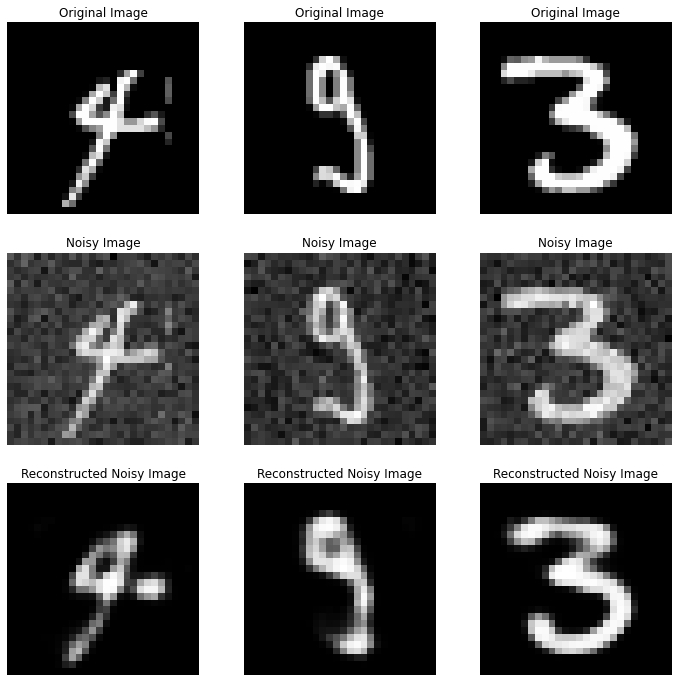

In [8]:
example_batch, _ = next(iter(mnist))
example_batch = example_batch.to(device)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

indices = np.argsort(np.random.rand(example_batch.shape[0]))[:3]

for col, index in enumerate(indices):

    example_image = example_batch[index].cpu()
    axes[0, col].imshow(example_image.squeeze(), cmap='gray')
    axes[0, col].set_title("Original Image")
    axes[0, col].axis('off')

    noisy_image = example_image + torch.randn_like(example_image) * 0.1
    axes[1, col].imshow(noisy_image.squeeze(), cmap='gray')
    axes[1, col].set_title("Noisy Image")
    axes[1, col].axis('off')

    noisy_image_input = noisy_image.flatten().unsqueeze(0).to(device)
    reconstructed_image = model(noisy_image_input)[0].reshape(1, image_size, image_size).detach().cpu()
    axes[2, col].imshow(reconstructed_image.squeeze(), cmap='gray')
    axes[2, col].set_title("Reconstructed Noisy Image")
    axes[2, col].axis('off')

plt.show()

In [9]:
# Save the 60,000 z values for our MNIST data

z_values = []

for batch_idx, batch_data in enumerate(mnist):

    # we only care about inputs, not labels
    x_real, _ = batch_data
    
    # flatten input images and move to device
    x_real = x_real.to(device)
    n_batch = x_real.shape[0]
    x_real = x_real.reshape(n_batch, -1)
    
    model.zero_grad()
    
    # train on a batch of inputs
    z = model.encoder(x_real)[0].cpu().detach().numpy()
    z_values.append(z)

z_values = np.concatenate(z_values, axis=0)

Now let's try to explore the latent space that our VAE has learned. We'll do the same thing we did for our standard autoencoder, except we'll sample according to the variance that our encoder outputs.

5900


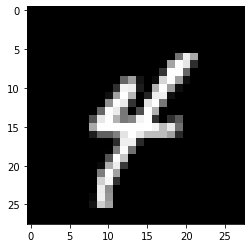

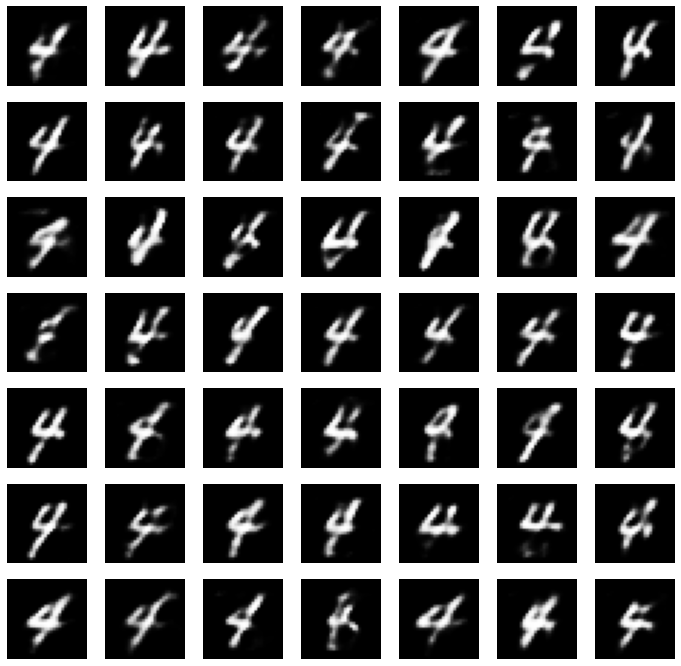

In [16]:
z_std = np.std(z_values)

# Grab a random image
seed = np.random.randint(10000)
print(seed)
# np.random.seed(1033)  # 8138, 5360, 
index = np.argsort(np.random.rand(example_batch.shape[0]))[0]
example_image = example_batch[index].cpu()
plt.imshow(example_image.reshape(image_size, image_size), cmap='gray')
plt.show()

# Find its latent representation in our autoencoder
image_input = example_image.flatten().unsqueeze(0).to(device)
mu, log_var = model.encoder(image_input)
mu = mu.detach().cpu()
log_var = log_var.detach().cpu()

# # You can print out the mean and variance of the Gaussian.
# print(torch.round(mu, decimals=4))
# print(log_var.exp())

n = 7
fig, axes = plt.subplots(nrows=n, ncols=n, figsize=(12, 12))

for i in range(n):
    for j in range(n):
        
        midpoint = (n - 1) // 2
        if i == midpoint and j == midpoint:
            offset = torch.zeros_like(mu)
        else:
#             offset = torch.normal(mean=0, std=4 * log_var.exp())
            offset = torch.normal(mean=torch.zeros_like(z), std=1 * z_std)

        new_z = mu + offset.float()

        new_image = model.decoder(new_z.to(device))
        new_image = new_image.reshape(1, image_size, image_size).detach().cpu()
        axes[i, j].imshow(new_image.squeeze(), cmap='gray')
        # axes[i, j].set_title(f"({xval:.2f}, {yval:.2f})")
        axes[i, j].axis('off')

plt.show()

In [11]:
# Do PCA on those z values
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
z2 = pca.fit_transform(z_values)

z2_percentiles = np.percentile(z2, [2.5, 97.5], axis=0)
z2_0_low, z2_1_low, z2_0_high, z2_1_high = z2_percentiles.reshape(-1)

We'll now use PCA to condense our latent space into two dimensions and visualize it. If you increase `n` and/or `dim_mult`, you can see more and/or a wider range of sampled images around the initially-encoded image.

4747


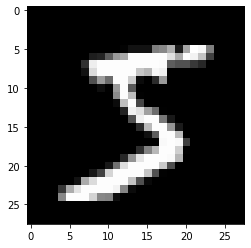

Initial image at  [ 0.13369633 -0.6941162 ]
Varying dim0 +/- 6.8 and dim1 +/- 3.5


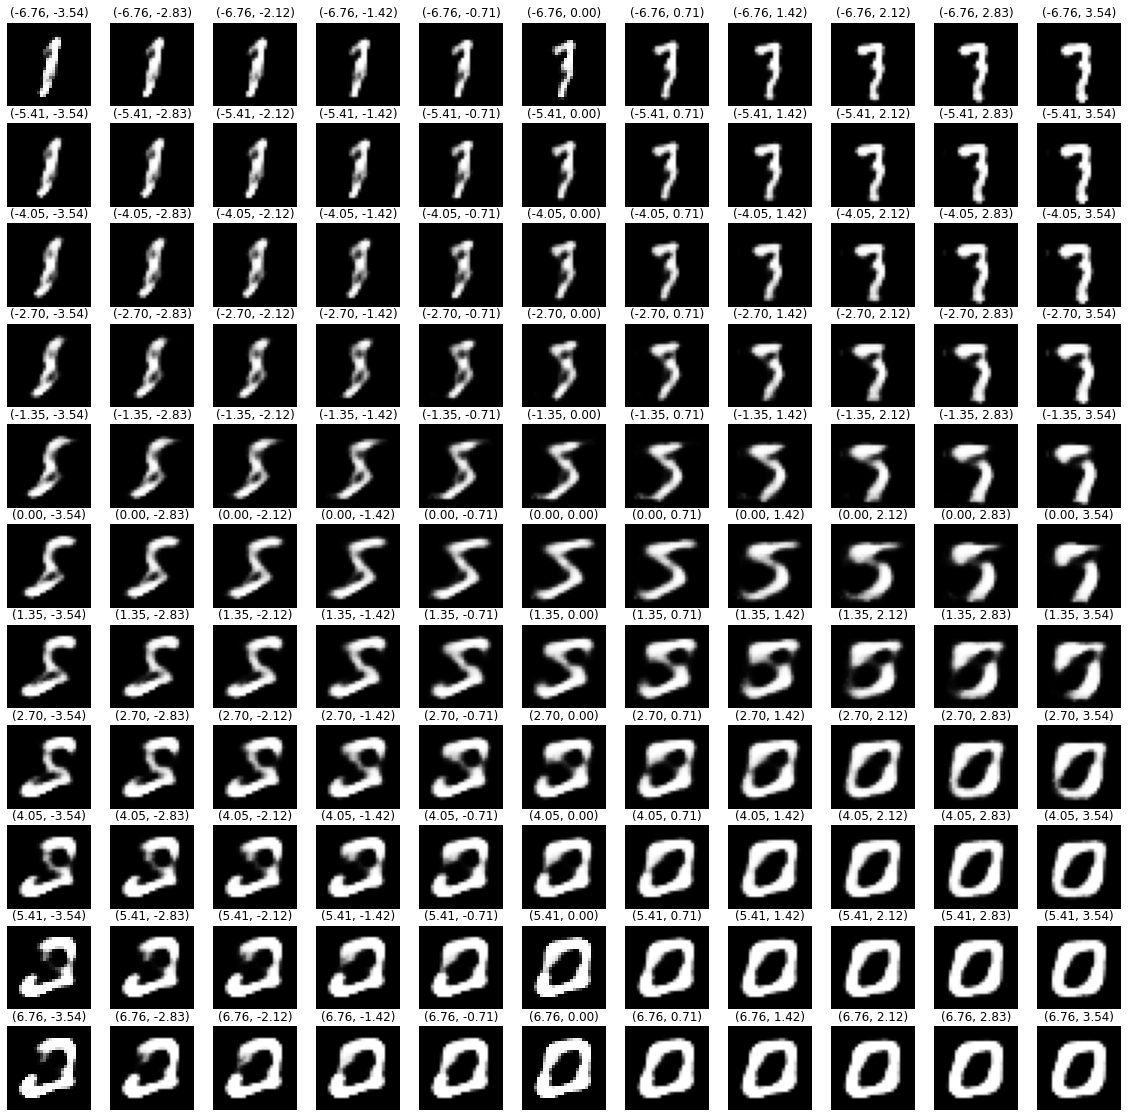

In [12]:
# Grab a random image
seed = np.random.randint(10000)
print(seed)
# 5854, 6616, 
np.random.seed(seed)
index = np.argsort(np.random.rand(example_batch.shape[0]))[0]
example_image = example_batch[index].cpu()
plt.imshow(example_image.reshape(image_size, image_size), cmap='gray')
plt.show()

# Find its latent representation in our autoencoder
image_input = example_image.flatten().unsqueeze(0).to(device)
z = model.encoder(image_input)[0].detach().cpu()
z_pca = pca.transform(z.numpy())[0]

# Try increasing dim_mult and/or n
n = 11
dim_mult = 4

dim0_offset = dim_mult * np.min((z_pca[0] - z2_0_low, z2_0_high - z_pca[0]))
dim1_offset = dim_mult * np.min((z_pca[1] - z2_1_low, z2_1_high - z_pca[1]))

print("Initial image at ", z_pca)
print(f"Varying dim0 +/- {dim0_offset:.1f} and dim1 +/- {dim1_offset:.1f}")

fig, axes = plt.subplots(nrows=n, ncols=n, figsize=(20, 20))

for i, xval in enumerate(np.linspace(-dim0_offset, dim0_offset, n)):
    for j, yval in enumerate(np.linspace(-dim1_offset, dim1_offset, n)):
        
        offset = pca.inverse_transform(np.array([[xval, yval]]))
        new_z = z + torch.tensor(offset).float()

        new_image = model.decoder(new_z.to(device))
        new_image = new_image.reshape(1, image_size, image_size).detach().cpu()
        axes[i, j].imshow(new_image.squeeze(), cmap='gray')
        axes[i, j].set_title(f"({xval:.2f}, {yval:.2f})")
        axes[i, j].axis('off')

plt.show()